In [ ]:
# Document Collection, Tokenizer, Normalization Pipeline on IMDB dataset
import os
import tarfile
import random
import pandas as pd
import numpy as np
import nltk
import logging
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# --- Use TensorFlow Datasets to load IMDB ---
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDB reviews dataset from TensorFlow Datasets
# as_supervised=True gives (text, label) pairs
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# --- Step 2: Collect 1000 positive + 1000 negative from the training split ---

documents = []
pos_count = 0
neg_count = 0
TARGET_PER_CLASS = 1000

# Convert TFDS dataset to NumPy for easy iteration
for text, label in tfds.as_numpy(ds_train.shuffle(25000, seed=42)):
    text_str = text.decode("utf-8")
    label_int = int(label)

    if label_int == 1 and pos_count < TARGET_PER_CLASS:
        documents.append((text_str, "positive"))
        pos_count += 1
    elif label_int == 0 and neg_count < TARGET_PER_CLASS:
        documents.append((text_str, "negative"))
        neg_count += 1

    if pos_count >= TARGET_PER_CLASS and neg_count >= TARGET_PER_CLASS:
        break

print(f"Collected {pos_count} positive and {neg_count} negative reviews.")

# Shuffle the dataset
random.shuffle(documents)

# Convert to pandas DataFrame
df = pd.DataFrame(documents, columns=["text", "label"])
df.head()

In [3]:
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

df[['text', 'label']].head()


Dataset shape: (2000, 2)

Label distribution:
label
negative    1000
positive    1000
Name: count, dtype: int64


,text,label
0,Your mind will not be satisfied by this nobud...,negative
1,Wow... what... a whirlwind. The 30's is a deca...,positive
2,Watching this movie again really brought back ...,positive
3,This is one of those movies that should have b...,negative
4,I've always liked Johnny Concho and I wish thi...,positive


In [4]:
first_review = df.loc[0, "text"]
first_review_tokens = word_tokenize(first_review)

print("=== FIRST REVIEW (text sample) ===")
print(first_review[:300], "...")

print("\n=== TOKENIZED OUTPUT ===")
print(first_review_tokens[:30])


=== FIRST REVIEW (text sample) ===
Your mind will not be satisfied by this nobudget doomsday thriller; but, pray, who's will? A youngish couple spends the actual end of the world in the hidden laboratory of some aliens masquerading as Church people.<br /><br />Small _apocalyptically themed outing, END OF THE WORLD has the ingenuity  ...

=== TOKENIZED OUTPUT ===
['Your', 'mind', 'will', 'not', 'be', 'satisfied', 'by', 'this', 'no\x97budget', 'doomsday', 'thriller', ';', 'but', ',', 'pray', ',', 'who', "'s", 'will', '?', 'A', 'youngish', 'couple', 'spends', 'the', 'actual', 'end', 'of', 'the', 'world']


In [5]:
def normalize_and_remove_stops(tokens):
    """
    1. Converts all tokens to lowercase (Normalization).
    2. Removes common English stop words.
    """
    # 1. Normalization: Convert to lowercase
    normalized_tokens = [token.lower() for token in tokens]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in normalized_tokens if token not in stop_words]
    
    return filtered_tokens

# Process our IMDB review tokens
cleaned_tokens = normalize_and_remove_stops(first_review_tokens)

print("--- NORMALIZATION & STOP WORDS REMOVAL ---")
print(cleaned_tokens[:30])


--- NORMALIZATION & STOP WORDS REMOVAL ---
['mind', 'satisfied', 'no\x97budget', 'doomsday', 'thriller', ';', ',', 'pray', ',', "'s", '?', 'youngish', 'couple', 'spends', 'actual', 'end', 'world', 'hidden', 'laboratory', 'aliens', 'masquerading', 'church', 'people.', '<', 'br', '/', '>', '<', 'br', '/']


In [6]:
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 1500
Test size : 500


In [7]:
vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1500, 5000)
Test TF-IDF shape : (500, 5000)


In [8]:
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 100 features:")
print(vocab[:100])


Vocabulary size: 5000

Sample of first 100 features:
['00' '000' '10' '100' '11' '11th' '12' '13' '14' '15' '16' '17' '18'
 '1930' '1930s' '1933' '1939' '1940' '1943' '1950' '1960' '1970' '1980'
 '1990' '1993' '1994' '1996' '1997' '1st' '20' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '24' '25' '2nd' '30' '30s' '3d' '3rd' '40'
 '40s' '45' '50' '50s' '5th' '60' '64' '70' '70s' '80' '80s' '85' '90'
 '90s' '95' '99' 'abandoned' 'abbey' 'abilities' 'ability' 'able' 'abroad'
 'absent' 'absolute' 'absolutely' 'absorbing' 'abstract' 'absurd' 'abu'
 'abuse' 'abused' 'abusive' 'academy' 'accent' 'accents' 'accept'
 'acceptable' 'accepted' 'accepting' 'access' 'accident' 'accidentally'
 'accompanied' 'accomplish' 'accomplished' 'according' 'account'
 'accurate' 'accused' 'acharya' 'achieve' 'achieved' 'achievement' 'act']


In [9]:
doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")


=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
I saw the 10p.m. showing and I must say that this movie was nothing special. Although I did not leave the theater wanting my time back (as I don't actually pay for movies anymore) I didn't really find any redeeming qualities.<br /><br />There were a few lines and such that made me chuckle, but mostl ...

Top 10 weighted terms:
theater              -> 0.2947
service              -> 0.2704
honest               -> 0.2131
pay                  -> 0.2089
film                 -> 0.1773
fan                  -> 0.1583
seeing               -> 0.1522
cg                   -> 0.1454
chuckle              -> 0.1414
rampant              -> 0.1381


In [10]:
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))


=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 105279
Total elements  : 7500000
Sparsity        : 1.4037%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000      10  100   11  11th   12   13   14      15
0  0.0  0.0  0.0000  0.0  0.0   0.0  0.0  0.0  0.0  0.0000
1  0.0  0.0  0.0655  0.0  0.0   0.0  0.0  0.0  0.0  0.1037
2  0.0  0.0  0.0000  0.0  0.0   0.0  0.0  0.0  0.0  0.0000
3  0.0  0.0  0.0000  0.0  0.0   0.0  0.0  0.0  0.0  0.0000
4  0.0  0.0  0.0000  0.0  0.0   0.0  0.0  0.0  0.0  0.0000


In [11]:
# Step 2: TF-IDF Feature Extraction on IMDB Reviews
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# We assume df from Step 1 exists with columns: ["text", "label"]

# -----------------------------
# 1. Train-Test Split
# -----------------------------
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
"""
TF-IDF (Term Frequency–Inverse Document Frequency) does:
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): down-weights words that appear in many documents.
Result: words that are frequent in a document but rare across the corpus get higher weights.
"""

vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


Train size: 1600
Test size : 400


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1600, 5000)
Test TF-IDF shape : (400, 5000)


In [12]:
# -----------------------------
# 3. Vocabulary Inspection
# -----------------------------
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 50 features:")
print(vocab[:50])



Vocabulary size: 5000

Sample of first 50 features:
['00' '000' '10' '100' '101' '11' '11th' '12' '13' '14' '15' '16' '17'
 '18' '1930' '1930s' '1933' '1939' '1940' '1943' '1950' '1960' '1970'
 '1976' '1980' '1990' '1993' '1994' '1995' '1996' '1997' '1st' '20' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '22' '24' '25'
 '2nd' '30' '305' '30s' '35']


In [13]:
# -----------------------------
# 4. Inspect TF-IDF Weights for a Single Review
# -----------------------------
import numpy as np

doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")



=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
This is a beautiful, rich, and very well-executed film with a rich and meaningful story. Basically, it tells how an old master story teller needs to find a (male) heir to carry on his craft, but ends up not getting what he expected in his very male-dominated world. The characters must then deal with ...

Top 10 weighted terms:
rich                 -> 0.3281
heir                 -> 0.3094
characters           -> 0.2119
desire               -> 0.1989
film                 -> 0.1865
traditional          -> 0.1816
compelling           -> 0.1689
complex              -> 0.1689
emotions             -> 0.1676
master               -> 0.1652


In [14]:
# -----------------------------
# 5. Visualizing TF-IDF Matrix Structure
# -----------------------------
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))



=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 111471
Total elements  : 8000000
Sparsity        : 1.3934%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000   10  100  101   11  11th   12   13   14
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0


In [15]:
# Baseline Model - Naive Bayes with TF-IDF

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# We assume:
# X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer already exist.

# -----------------------------
# 1. Train Naive Bayes Classifier
# -----------------------------

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

# -----------------------------
# 2. Predictions
# -----------------------------

y_pred = nb_model.predict(X_test_tfidf)

print("\n=== SAMPLE PREDICTIONS ===")
for i in range(5):
    print(f"Review {i}: Predicted={y_pred[i]}, Actual={y_test[i]}")


Model training complete.

=== SAMPLE PREDICTIONS ===
Review 0: Predicted=negative, Actual=negative
Review 1: Predicted=negative, Actual=negative
Review 2: Predicted=positive, Actual=positive
Review 3: Predicted=negative, Actual=negative
Review 4: Predicted=negative, Actual=negative



=== CONFUSION MATRIX ===
                 Pred_Positive  Pred_Negative
Actual_Positive            172             28
Actual_Negative             15            185


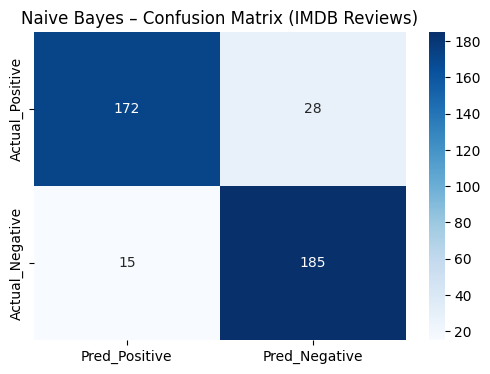


TP=172, FN=28, FP=15, TN=185


In [16]:
# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
cm_df = pd.DataFrame(cm,
                     index=["Actual_Positive", "Actual_Negative"],
                     columns=["Pred_Positive", "Pred_Negative"])

print("\n=== CONFUSION MATRIX ===")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes – Confusion Matrix (IMDB Reviews)")
plt.show()

# Extract values
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

print(f"\nTP={TP}, FN={FN}, FP={FP}, TN={TN}")


In [17]:
# -----------------------------
# 4. Evaluation Metrics
# -----------------------------

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="positive")
recall    = recall_score(y_test, y_pred, pos_label="positive")
f1        = f1_score(y_test, y_pred, pos_label="positive")

print("\n=== METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== METRICS ===
Accuracy : 0.8925
Precision: 0.9198
Recall   : 0.8600
F1-score : 0.8889

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.87      0.93      0.90       200
    positive       0.92      0.86      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [18]:
# -----------------------------
# 5. Interpretation of Naive Bayes
# -----------------------------

print("\n=== INTERPRETATION OF RESULTS ===")

if FN > FP:
    print("- The model is making more **False Negatives** (positive reviews predicted as negative).")
    print("  → This means the classifier struggles to detect subtle positive sentiment.")
    
if FP > FN:
    print("- The model is making more **False Positives** (negative reviews predicted as positive).")
    print("  → The model is confused by emotionally strong negative words that appear in positive contexts.")

print("- High precision means predictions marked as 'positive' are usually correct.")
print("- High recall means the model can successfully find most positive reviews.")
print("- A gap between precision and recall indicates bias toward one class.")

print("\nGeneral Observations:")
print("* Naive Bayes works well with TF-IDF because it assumes word independence.")
print("* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').")
print("* It also struggles with sarcasm, irony, and highly figurative language.")



=== INTERPRETATION OF RESULTS ===
- The model is making more **False Negatives** (positive reviews predicted as negative).
  → This means the classifier struggles to detect subtle positive sentiment.
- High precision means predictions marked as 'positive' are usually correct.
- High recall means the model can successfully find most positive reviews.
- A gap between precision and recall indicates bias toward one class.

General Observations:
* Naive Bayes works well with TF-IDF because it assumes word independence.
* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').
* It also struggles with sarcasm, irony, and highly figurative language.
